# Amazon product review opinions mining

### Import all the packges required

In [1]:
from keras.models import Model, Sequential
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.initializers import glorot_uniform
from keras.preprocessing import text, sequence
from keras.regularizers import l2
from keras.constraints import maxnorm
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
import os
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import rcParams
from collections import Counter


#### Import the pretrained word embeddings

In [2]:
#!kaggle datasets download -d watts2/glove6b50dtxt
# download glove6b50dtxt from kaggle website.
#https://www.kaggle.com/watts2/glove6b50dtxt

### Feature Engineering

In [3]:
df=pd.read_csv('phone_reviews.csv')
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17248 entries, 0 to 17247
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    17248 non-null  int64 
 1   mobile_names  17248 non-null  object
 2   asin          17248 non-null  object
 3   title         17248 non-null  object
 4   body          17248 non-null  object
 5   star          17248 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 808.6+ KB


Index(['Unnamed: 0', 'mobile_names', 'asin', 'title', 'body', 'star'], dtype='object')

In [4]:
df.head()

,Unnamed: 0,mobile_names,asin,title,body,star
0,0,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nvalue money go it\n,update 15082020never give chance regret go ah...,4
1,1,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\n\n,title obviously monsterand good performance,5
2,2,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbest budget phone india\n,brilliant camera huge battery life brilliant ...,5
3,3,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbattery life upto mark\n,writing review using 6 daysi bought sumsung p...,3
4,4,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nfeeling cheated\n,defective product received gets 8 12 hours ch...,1


In [5]:
df['star']-=1
x=df['body']
y=df['star']

In [6]:
df['star']

0        3
1        4
2        4
3        2
4        0
        ..
17243    3
17244    4
17245    3
17246    1
17247    0
Name: star, Length: 17248, dtype: int64

In [7]:
df.head()

,Unnamed: 0,mobile_names,asin,title,body,star
0,0,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nvalue money go it\n,update 15082020never give chance regret go ah...,3
1,1,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\n\n,title obviously monsterand good performance,4
2,2,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbest budget phone india\n,brilliant camera huge battery life brilliant ...,4
3,3,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbattery life upto mark\n,writing review using 6 daysi bought sumsung p...,2
4,4,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nfeeling cheated\n,defective product received gets 8 12 hours ch...,0


Split the data of training and evaluating the model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [9]:
X_train

16828                  awesome phone great camera quality 
5421      samsung performance seems launched without pr...
15599     4th mi phone 3 years earlier ones goodbut ext...
1598      weak signal antennaflash wide angle camera do...
15949     side bottom border area keyboard keys working...
                               ...                        
11284                   first sell first order mobile nice
11964     m31 looks identical galaxy m30s new galaxy m3...
5390      got dad writing review months use great displ...
860       phone delivered without sim ejector pin outer...
15795     working pls dont buy phone listen carefully a...
Name: body, Length: 13798, dtype: object

In [10]:
sentence_lengths=X_train.apply(lambda x:len(x.split()))

In [11]:
sentence_lengths

16828      5
5421      42
15599     31
1598      33
15949    108
        ... 
11284      6
11964     62
5390      14
860       14
15795     50
Name: body, Length: 13798, dtype: int64

In [12]:
sentence_lengths.describe()

count    13798.000000
mean        47.114727
std         54.091311
min          0.000000
25%         16.000000
50%         33.000000
75%         56.000000
max        778.000000
Name: body, dtype: float64

In [13]:
sentence_lengths.head()

16828      5
5421      42
15599     31
1598      33
15949    108
Name: body, dtype: int64

## Train models

### 1. LSTM (Long Short Term Memory) Recurrent Neural Network

### Hyperparameters

In [14]:
maxlen=100
loss='categorical_crossentropy'
batch_size=32
optimizer='adam'
epochs=10

In [15]:
#this code is imported from coursera sequential models assignment
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

#convert number to one_hot vector
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

#sentences to word indices
def sentences_to_indices(X, word_to_index):  
    m = X.shape[0]                                   # number of training examples
    X_indices = np.zeros(m)
    X_indices=[]
    for i in range(m):                               # loop over training examples

        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']
        #sentence_words=X[i].split(' ')
        # Initialize j to 0
        j=0
        # Loop over the words of sentence_words
        li=np.zeros(len(sentence_words))
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                li[j] = word_to_index[w]
            except:
               # print(w)
                li[j]= 0
            # Increment j to j + 1
            j += 1
        X_indices.append(li)    
    X_indices=np.array(X_indices)
    return X_indices

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1              
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [16]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')
#test
word = "good"
idx = 567
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of good in the vocabulary is 164328
the 567th word in the vocabulary is ,6


In [17]:
X1 = np.array(["the phone is good", "very bad", "no star rating"])
X1_indices = sentences_to_indices(X1,word_to_index)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['the phone is good' 'very bad' 'no star rating']
X1_indices =
 [array([357266., 283483., 192973., 164328.]) array([377946.,  65963.])
 array([262350., 341678., 301038.])]


In [18]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


Building the Model of 2 layers of LSTM

In [19]:
def lstmModel(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5, activation=None)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)
    
    return model

In [20]:
model = lstmModel((100,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          91648     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

In [21]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

**Prepare the data for training**

In [22]:
X_train_np=np.array(X_train)
y_train_np=np.array(y_train)
X_test_np=np.array(X_test)
y_test_np=np.array(y_test)

Y_train_oh = convert_to_one_hot(y_train_np, C = 5)
Y_test_oh = convert_to_one_hot(y_test_np, C = 5)

X_test_indices = sentences_to_indices(X_test_np, word_to_index)
X_train_indices = sentences_to_indices(X_train_np, word_to_index)

X_train_indices = sequence.pad_sequences(X_train_indices, maxlen=100)
X_test_indices = sequence.pad_sequences(X_test_indices, maxlen=100)

In [23]:
y_train_np

array([4, 2, 0, ..., 4, 0, 0], dtype=int64)

In [24]:
model_history=model.fit(X_train_indices, Y_train_oh, epochs = epochs, batch_size = batch_size, shuffle=True)

Epoch 1/10
432/432 [==============================] - 103s 238ms/step - loss: 0.9986 - accuracy: 0.6376
Epoch 2/10
432/432 [==============================] - 102s 237ms/step - loss: 0.5357 - accuracy: 0.8216
Epoch 3/10
432/432 [==============================] - 100s 232ms/step - loss: 0.2565 - accuracy: 0.9193
Epoch 4/10
432/432 [==============================] - 102s 236ms/step - loss: 0.1530 - accuracy: 0.9519
Epoch 5/10
432/432 [==============================] - 111s 258ms/step - loss: 0.0996 - accuracy: 0.9677
Epoch 6/10
432/432 [==============================] - 104s 241ms/step - loss: 0.0844 - accuracy: 0.9750
Epoch 7/10
432/432 [==============================] - 106s 246ms/step - loss: 0.0549 - accuracy: 0.9843
Epoch 8/10
432/432 [==============================] - 103s 238ms/step - loss: 0.0772 - accuracy: 0.9763
Epoch 9/10
432/432 [==============================] - 105s 242ms/step - loss: 0.0533 - accuracy: 0.9843
Epoch 10/10
432/432 [==============================] - 105s 244m

In [25]:
test_preds=model.predict(X_test_indices)

In [26]:
test_preds

array([[9.9985433e-01, 5.2791092e-06, 6.4395658e-06, 9.1624770e-06,
        1.2481275e-04],
       [1.1937438e-04, 4.9349569e-06, 3.7197813e-05, 2.4359293e-04,
        9.9959487e-01],
       [1.5918791e-05, 2.3779561e-05, 3.4077464e-05, 9.9947995e-01,
        4.4630733e-04],
       ...,
       [1.9134384e-05, 5.0626977e-07, 7.4842060e-06, 5.4268894e-05,
        9.9991858e-01],
       [7.2452685e-06, 1.7965469e-07, 4.5042530e-06, 3.4600271e-05,
        9.9995351e-01],
       [3.1004394e-05, 9.5491429e-05, 2.0387419e-04, 9.9913484e-01,
        5.3475087e-04]], dtype=float32)

In [27]:
test_preds = [np.argmax(pred) for pred in test_preds]

In [28]:
np.argmax([7.7426394e-06, 1.2770720e-06, 1.9373367e-06, 6.3961576e-05,
        9.9992502e-01])

4

In [29]:
X_test[0]

' update 15082020never give chance regret go aheadthe icons looks great set spherlue icons theam looks better dark mode even though 6000 mah always leaves phone charging go bed like see phone 100 every morning turned fast charging option affect batterymonster 1 battery 55two day battery standby normal easy2display 4995super amaload full hd superb display3design35it a6000mah battery still looking bulky noglass body cares put back cover opinion dont spend money glass body uses back covers4 camera 35back camera pretty good front cameras low light output low many features available slow super slow videos available5 osui 55android 10 one ui6finger print reader face lock 35 face lock finger print reader fast7processor performance 355exynos 9611 meant pubg gamers perfect heavy gamer lag ang hang till processor outdated8 charging 255 fast charging provided 15w charger iy takes 3 hrs fully reacharge phone9 accessories 25no earphone back cover screenguard order backcover tempered glass placing o

In [37]:
test_preds[0:5]

[0, 4, 3, 0, 4]

In [38]:
train_preds=model.predict(X_train_indices)

In [39]:
train_preds

array([[1.3473392e-05, 7.9048908e-07, 1.0624972e-05, 1.9881217e-04,
        9.9977630e-01],
       [1.7605718e-05, 1.1861497e-05, 9.9995017e-01, 7.7628638e-06,
        1.2585311e-05],
       [9.9985433e-01, 5.2791092e-06, 6.4395658e-06, 9.1624770e-06,
        1.2481275e-04],
       ...,
       [1.9000199e-04, 9.4727320e-06, 1.0254991e-04, 9.2402234e-04,
        9.9877399e-01],
       [9.9996626e-01, 4.8076799e-06, 1.2051206e-05, 1.5331980e-05,
        1.5580621e-06],
       [9.9975485e-01, 5.2289288e-05, 2.4174784e-05, 4.1101481e-05,
        1.2746903e-04]], dtype=float32)

In [40]:
train_preds = [np.argmax(pred) for pred in train_preds]

In [41]:
train_preds[0:5]

[4, 2, 0, 0, 1]

In [42]:
from sklearn.metrics import cohen_kappa_score,accuracy_score
print("Test Accuracy score : %.3f" % accuracy_score(y_test.astype('int'),test_preds))
print("Train Accuracy score : %.3f" % accuracy_score(y_train.astype('int'),train_preds))

Test Accuracy score : 0.983
Train Accuracy score : 0.989


In [43]:
def sentiment_category(score):
    if score >= 4:
        return "positive"
    elif score <= 2:
        return "negative"
    else:
        return "neutral"

In [44]:

df_indices = sentences_to_indices(np.array(df['body']), word_to_index)
df_indices = sequence.pad_sequences(df_indices, maxlen=100)
df_preds=model.predict(df_indices)
df_preds = [np.argmax(pred) for pred in df_preds]
df['sentiment_score']=df_preds
df['review_category']=df['sentiment_score'].apply(lambda x:sentiment_category(x))

In [45]:
df_indices

array([[339258, 248489, 162321, ...,  99771, 173296, 157105],
       [     0,      0,      0, ...,      0, 164328, 281311],
       [     0,      0,      0, ...,      0, 303029, 283483],
       ...,
       [     0,      0,      0, ..., 164328, 292066, 159439],
       [     0,      0,      0, ..., 292998, 269953, 124912],
       [     0,      0,      0, ..., 271173, 117550,      0]])

In [46]:
df_preds[0:5]

[3, 4, 4, 2, 0]

In [47]:
df.head()

,Unnamed: 0,mobile_names,asin,title,body,star,sentiment_score,review_category
0,0,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nvalue money go it\n,update 15082020never give chance regret go ah...,3,3,neutral
1,1,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\n\n,title obviously monsterand good performance,4,4,positive
2,2,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbest budget phone india\n,brilliant camera huge battery life brilliant ...,4,4,positive
3,3,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbattery life upto mark\n,writing review using 6 daysi bought sumsung p...,2,2,negative
4,4,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nfeeling cheated\n,defective product received gets 8 12 hours ch...,0,0,negative


Text(0.5, 1.0, 'Distribution of Reviews Category')

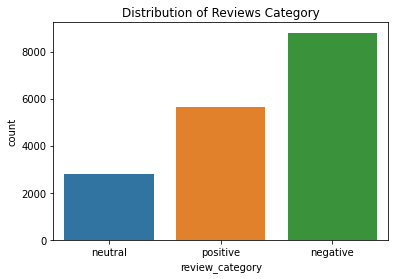

In [48]:
sns.countplot(df['review_category']).set_title("Distribution of Reviews Category")

In [49]:
positive_reviews=df.loc[df['review_category']=='positive','body'].tolist() # extracting all positive reviews and converting to a list
positive_reviews[0:5]

[' title obviously monsterand good performance',
 ' brilliant camera huge battery life brilliant display addition premium feeling samsung shame phones launch delayed due lockdownhighly recommended phone ',
 ' love one best class no1 best budget mobile samsung mobile brand also global no1 brand world great one rating 5star thanks samsung n amazon',
 ' value moneyi gamer cant say gaming performance buying normal usage phone great 6gb ram128 gb internal storage amoled display satisfiedi using samsung phones start samsungs amoled screen attracted feel gives simply amazingbut battery dont seem 6000 mahas far non gamer concerned phone best price range',
 ' nice mobile good']

In [50]:
negative_reviews=df.loc[df['review_category']=='negative','body'].tolist() # extracting all negative reviews and converting to a list
negative_reviews[0:5]

[' writing review using 6 daysi bought sumsung phone 7 years hoping could good phone samsung disappointed lotthey claim 6000mah battery drain like 3000mah take almost 230hrs charge 10 90 fast charging fast charging market gimic clail monester like features iebattery 6000mah 15w fast charge ete reality far far away claimsothers features per price range thinking battery packed phone fast chargethen would sugget plz search others phone range',
 ' defective product received gets 8 12 hours charging amazon exchanging product',
 ' poor performance hangs aloft even dont use gaming app browsing phone lacks inspite 6 gb ram product serves zero rating please dont buy wastage money refund policy device',
 ' writing review using 6 daysi bought sumsung phone 7 years hoping could good phone samsung disappointed lotthey claim 6000mah battery drain like 3000mah take almost 230hrs charge 10 90 fast charging fast charging market gimic clail monester like features iebattery 6000mah 15w fast charge ete re

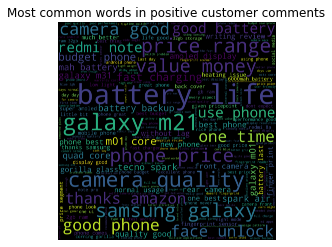

In [45]:

wordcloud = WordCloud(height=4000, width=4000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df.loc[df['review_category']=='positive','body'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in positive customer comments")
plt.axis('off')
plt.show()

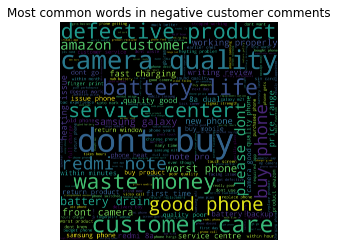

In [46]:
from wordcloud import WordCloud
wordcloud = WordCloud(height=4000, width=4000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df.loc[df['review_category']=='negative','body'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in negative customer comments")
plt.axis('off')
plt.show()

#### Generating Bigrams
Bigrams are more effective than unigrams

In [51]:
def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn)

In [52]:
def generateNGram(text,n):
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams]

In [53]:
positive_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in positive_reviews]
negative_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in negative_reviews]

In [54]:
def plotMostCommonWords(reviews_list,topn=30,title="Common Review Words",color="blue",axis=None): #default number of words is given as 30
    top_words=getMostCommon(reviews_list,topn=topn)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(topn))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(topn))

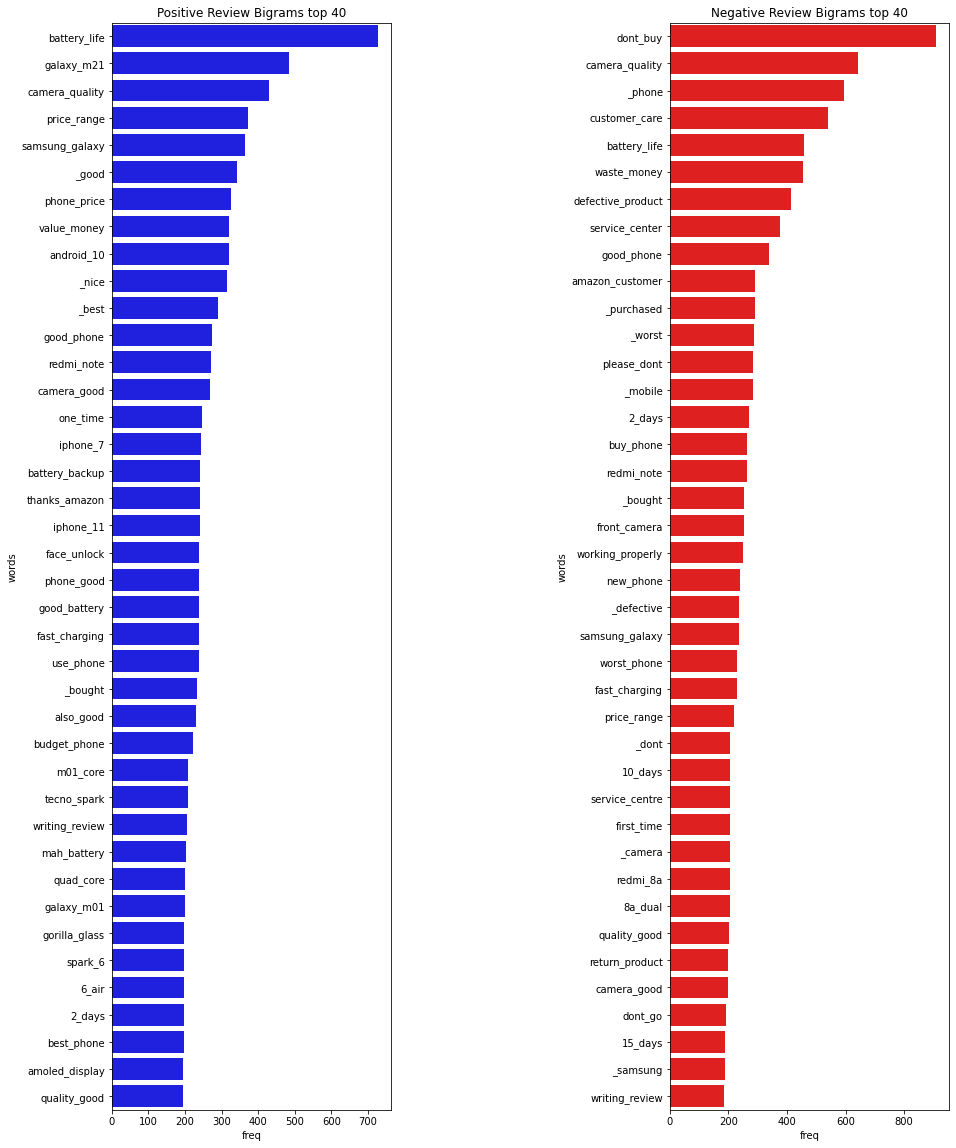

In [55]:
rcParams['figure.figsize'] = 15,20
fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=1)
plotMostCommonWords(positive_reviews_bigrams,40,'Positive Review Bigrams',axis=ax[0])

plotMostCommonWords(negative_reviews_bigrams,40,'Negative Review Bigrams',color="red",axis=ax[1])

#### Save the model

In [122]:
import pickle

In [43]:
model.save("lstm.h5")

In [123]:
from keras.models import load_model

In [126]:
ann_path = "lstm.h5"
lstm = load_model(ann_path, compile=False)
lstm.compile(optimizer='adam', loss='categorical_crossentropy')

In [127]:
test_sentence_preds_model_load = lstm.predict(test_sentence_indices)
test_sentence_preds_model_load

array([[0.0482681 , 0.31250983, 0.47529587, 0.11370067, 0.05022554]],
      dtype=float32)

In [52]:
test_sentence = np.array(["i am okay with the phone"])
test_sentence

array(['i am okay with the phone'], dtype='<U24')

In [53]:
test_sentence_indices = sentences_to_indices(test_sentence, word_to_index)
test_sentence_indices

array([[185457.,  52943., 268788., 388711., 357266., 283483.]])

In [54]:
# test_indices = sequence.pad_sequences(test_sentence_indices, maxlen=100)
# test_indices

In [55]:
test_sentence_preds = model.predict(test_sentence_indices)
test_sentence_preds

array([[0.31066602, 0.2913219 , 0.21954769, 0.08221804, 0.09624633]],
      dtype=float32)

In [56]:
test_sentence_preds = np.argmax(test_sentence_preds)
test_sentence_preds

0

In [57]:
test_sentence_review = sentiment_category(test_sentence_preds)
test_sentence_review

'negative'

### 2. VADER( Valence Aware Dictionary for Sentiment Reasoning) 

In [58]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Debidutta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [60]:
data = df
data.head()

,Unnamed: 0,mobile_names,asin,title,body,star,sentiment_score,review_category
0,0,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nvalue money go it\n,update 15082020never give chance regret go ah...,3,3,neutral
1,1,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\n\n,title obviously monsterand good performance,4,4,positive
2,2,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbest budget phone india\n,brilliant camera huge battery life brilliant ...,4,4,positive
3,3,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbattery life upto mark\n,writing review using 6 daysi bought sumsung p...,2,2,negative
4,4,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nfeeling cheated\n,defective product received gets 8 12 hours ch...,0,0,negative


In [61]:
data['body'].isnull().any()

False

In [62]:
sid.polarity_scores(df.loc[0]['body'])

{'neg': 0.058, 'neu': 0.756, 'pos': 0.185, 'compound': 0.9799}

In [63]:
data['vader_scores'] = data['body'].apply(lambda review: sid.polarity_scores(review))
data.head()

,Unnamed: 0,mobile_names,asin,title,body,star,sentiment_score,review_category,vader_scores
0,0,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nvalue money go it\n,update 15082020never give chance regret go ah...,3,3,neutral,"{'neg': 0.058, 'neu': 0.756, 'pos': 0.185, 'co..."
1,1,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\n\n,title obviously monsterand good performance,4,4,positive,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou..."
2,2,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbest budget phone india\n,brilliant camera huge battery life brilliant ...,4,4,positive,"{'neg': 0.166, 'neu': 0.397, 'pos': 0.437, 'co..."
3,3,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbattery life upto mark\n,writing review using 6 daysi bought sumsung p...,2,2,negative,"{'neg': 0.042, 'neu': 0.796, 'pos': 0.162, 'co..."
4,4,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nfeeling cheated\n,defective product received gets 8 12 hours ch...,0,0,negative,"{'neg': 0.23, 'neu': 0.635, 'pos': 0.135, 'com..."


In [64]:
data['compound'] = data['vader_scores'].apply(lambda score_dict: score_dict['compound'])
df.head()

,Unnamed: 0,mobile_names,asin,title,body,star,sentiment_score,review_category,vader_scores,compound
0,0,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nvalue money go it\n,update 15082020never give chance regret go ah...,3,3,neutral,"{'neg': 0.058, 'neu': 0.756, 'pos': 0.185, 'co...",0.9799
1,1,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\n\n,title obviously monsterand good performance,4,4,positive,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...",0.4404
2,2,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbest budget phone india\n,brilliant camera huge battery life brilliant ...,4,4,positive,"{'neg': 0.166, 'neu': 0.397, 'pos': 0.437, 'co...",0.8020
3,3,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nbattery life upto mark\n,writing review using 6 daysi bought sumsung p...,2,2,negative,"{'neg': 0.042, 'neu': 0.796, 'pos': 0.162, 'co...",0.7845
4,4,"Samsung Galaxy M21 (Midnight Blue, 4GB RAM, 64...",B07HGJJ559,\nfeeling cheated\n,defective product received gets 8 12 hours ch...,0,0,negative,"{'neg': 0.23, 'neu': 0.635, 'pos': 0.135, 'com...",-0.2960


### feature selection technique 2 (discard)

In [96]:
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Debidutta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
ps=PorterStemmer()

In [98]:
list1=[]
for i in range(len(df['body'])):
    review=df["body"][i]
    review=re.sub("[^a-zA-Z]"," ",review)
    review=review.lower()
    review=review.split()    
    review=[ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review=" ".join(review)
    list1.append(review)

In [99]:
#vectorization
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=3000, ngram_range=(1,4))
x=cv.fit_transform(list1).toarray()

In [100]:
from sklearn.model_selection import train_test_split
new_x_train,new_x_test,new_y_train,new_y_test=train_test_split(x,df['star'],test_size=0.2,random_state=0)

### 3. XGBoost

In [66]:
from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

In [101]:
model_xgb = XGBClassifier()

In [132]:
model_xgb.fit(X_train_indices, y_train_np)

c:\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [134]:
xgb_test_preds=model_xgb.predict(X_test_indices)

In [135]:
print("Test Accuracy score : %.3f" % accuracy_score(y_test.astype('int'),xgb_test_preds))

Test Accuracy score : 0.994


In [141]:
xgb_test_preds_2=model_xgb.predict(df_indices)
len(xgb_test_preds_2)

17248

In [144]:
print("Test Accuracy score : %.3f" % accuracy_score(df['star'].astype('int'),xgb_test_preds_2))

Test Accuracy score : 0.998


In [138]:
file_name = "xgb_reg.pkl"

# save
pickle.dump(model_xgb, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [139]:
xgb_test_preds=xgb_model_loaded.predict(X_test_indices)
print("Test Accuracy score : %.3f" % accuracy_score(y_test.astype('int'),xgb_test_preds))

Test Accuracy score : 0.994


### 4. ANN (discard)

In [83]:
from keras.models import Sequential
from keras.layers import Dense

In [146]:
ann_model = Sequential()
ann_model.add(Dense(units =3000, activation = "relu"))
ann_model.add(Dense(units =3000, activation = "relu"))

ann_model.add(Dense(units = 1, activation = "sigmoid"))
ann_model.compile(optimizer = "adam",loss = "binary_crossentropy",metrics = ["accuracy"])
ann_model.fit(X_train_indices, y_train_np, epochs = 10)

Epoch 1/10
432/432 [==============================] - 25s 58ms/step - loss: -3536507633664.0000 - accuracy: 0.0560
Epoch 2/10
432/432 [==============================] - 27s 62ms/step - loss: -59045092261888.0000 - accuracy: 0.0554
Epoch 3/10
432/432 [==============================] - 29s 67ms/step - loss: -246868378386432.0000 - accuracy: 0.0554
Epoch 4/10
432/432 [==============================] - 30s 69ms/step - loss: -618288124002304.0000 - accuracy: 0.0554
Epoch 5/10
432/432 [==============================] - 29s 68ms/step - loss: -1210793827762176.0000 - accuracy: 0.0554
Epoch 6/10
432/432 [==============================] - 30s 70ms/step - loss: -2051038680973312.0000 - accuracy: 0.0554
Epoch 7/10
432/432 [==============================] - 30s 70ms/step - loss: -3152291515334656.0000 - accuracy: 0.0554
Epoch 8/10
432/432 [==============================] - 31s 71ms/step - loss: -4531520672890880.0000 - accuracy: 0.0554
Epoch 9/10
432/432 [==============================] - 32s 75ms/

In [147]:
ann_test_preds=ann_model.predict(X_test_indices)
# ann_test_preds = [np.argmax(pred) for pred in ann_test_preds]

In [149]:
print("Test Accuracy score : %.3f" % accuracy_score(y_test.astype('int'),ann_test_preds))

Test Accuracy score : 0.061


In [150]:
ann_model.save("ann.h5")

### 5. Naive Bayes

In [90]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train_indices, y_train_np)

MultinomialNB()

In [120]:
nb_test_preds=NB_classifier.predict(X_test_indices)

In [121]:
print("Test Accuracy score : %.3f" % accuracy_score(y_test.astype('int'),nb_test_preds))

Test Accuracy score : 0.409


In [151]:
file_name = "nb_clf.pkl"

# save
pickle.dump(NB_classifier, open(file_name, "wb"))

# load
nb_model_loaded = pickle.load(open(file_name, "rb"))

In [152]:
nb_test_preds=nb_model_loaded.predict(X_test_indices)
print("Test Accuracy score : %.3f" % accuracy_score(y_test.astype('int'),nb_test_preds))

Test Accuracy score : 0.409


### 6. Decision Tree

In [93]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0)

In [94]:
dt_clf.fit(X_train_indices, y_train_np)

DecisionTreeClassifier(random_state=0)

In [114]:
dt_test_preds=dt_clf.predict(X_test_indices)
# dt_test_preds = [np.argmax(pred) for pred in dt_test_preds]
print("Test Accuracy score : %.3f" % accuracy_score(y_test.astype('int'),dt_test_preds))

Test Accuracy score : 0.995


In [129]:
(df[0:100]).shape

(100, 10)

In [153]:
file_name = "dt_clf.pkl"

# save
pickle.dump(dt_clf, open(file_name, "wb"))

# load
DT_model_loaded = pickle.load(open(file_name, "rb"))

In [154]:
dt_test_preds=DT_model_loaded.predict(X_test_indices)
# dt_test_preds = [np.argmax(pred) for pred in dt_test_preds]
print("Test Accuracy score : %.3f" % accuracy_score(y_test.astype('int'),dt_test_preds))

Test Accuracy score : 0.995
